In [16]:
### Imports
import pypsa
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import sys
import importlib

# Verbindungen zu den Ordnern der Einzelaufgaben

sys.path.append("../processed_spatial_res")
from get_spatial_res import get_spatial_res

sys.path.append("../processed_capacity_factors")
import cutout_local
importlib.reload(cutout_local)
from cutout_local import get_excluders, get_availability, get_pv_and_wind


sys.path.append("../processed_existing_conv_pp")
import get_existing_conv_pp
importlib.reload(get_existing_conv_pp)
from get_existing_conv_pp import get_existing_conv_pp

sys.path.append("../processed_load_profile")
import load_processing
importlib.reload(load_processing)
from load_processing import regional_load


In [13]:
### Spatial resolution

regions = get_spatial_res()
regions.head()

,geometry,GID_0,COUNTRY,NAME_1,REP_POINT
region_5,,,,,
Kärnten/Steiermark,"POLYGON ((14.43537 46.44343, 14.43537 46.44345...",AUT,Austria,Kärnten,POINT (14.98609 47.10053)
Niederösterreich/Burgenland,"POLYGON ((16.06715 46.84889, 16.0672 46.84884,...",AUT,Austria,Burgenland,POINT (15.92138 47.92607)
Oberösterreich/Salzburg,"POLYGON ((13.69947 47.00479, 13.69858 47.00534...",AUT,Austria,Oberösterreich,POINT (13.86111 47.85873)
Tirol/Vorarlberg,"MULTIPOLYGON (((12.39612 46.71143, 12.39598 46...",AUT,Austria,Tirol,POINT (10.82959 47.25349)
Wien,"POLYGON ((16.29905 48.12999, 16.29897 48.12999...",AUT,Austria,Wien,POINT (16.37248 48.2208)


In [30]:
### Load Zeitreihe

load_regions = regional_load()
load_regions.head()
print(load_regions)

                     Kärnten/Steiermark  Niederösterreich/Burgenland  \
time                                                                   
2013-01-01 00:00:00         6713.397737                  7392.725220   
2013-01-01 01:00:00         6785.509837                  7472.134330   
2013-01-01 02:00:00         6790.853449                  7478.018661   
2013-01-01 03:00:00         6902.301714                  7600.744356   
2013-01-01 04:00:00         6902.301714                  7600.744356   
...                                 ...                          ...   
2013-12-31 19:00:00         5285.800593                  5820.669783   
2013-12-31 20:00:00         5714.984417                  6293.282639   
2013-12-31 21:00:00         6141.433730                  6762.884280   
2013-12-31 22:00:00         6671.314808                  7346.383927   
2013-12-31 23:00:00         6685.125026                  7361.591599   

                     Oberösterreich/Salzburg  Tirol/Vorarlberg 

In [35]:
### Time resolution

TIME_RES = "3h" 

# 1) resample 
load_regions = load_regions.resample(TIME_RES).mean()
pv_cf_df     = pv_cf_df.resample(TIME_RES).mean()
wind_cf_df   = wind_cf_df.resample(TIME_RES).mean()

# 2) common index 
common_index = (
    load_regions.index
    .intersection(pv_cf_df.index)
    .intersection(wind_cf_df.index)
)

load_regions = load_regions.loc[common_index]
pv_cf_df     = pv_cf_df.loc[common_index]
wind_cf_df   = wind_cf_df.loc[common_index]

######Muss geklärt werden

In [25]:
#pypsa Network erstellen

n = pypsa.Network()
n.set_snapshots(load_regions.index)

n


ValueError: Snapshots must not be empty.

In [ ]:
for c in ["electricity", "solar", "wind", "gas", "hydro"]:
    if c not in n.carriers.index:
        n.add("Carrier", c)

n.carriers


In [31]:
for region, row in regions.iterrows():
    n.add(
        "Bus",
        name=region,
        x=row["REP_POINT"].x,
        y=row["REP_POINT"].y,
        carrier="electricity"
    )

n.buses


,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
name,,,,,,,,,,,,,
Kärnten/Steiermark,1.0,,14.986091,47.100529,electricity,,,1.0,0.0,inf,PQ,,
Niederösterreich/Burgenland,1.0,,15.921376,47.926071,electricity,,,1.0,0.0,inf,PQ,,
Oberösterreich/Salzburg,1.0,,13.861108,47.858727,electricity,,,1.0,0.0,inf,PQ,,
Tirol/Vorarlberg,1.0,,10.829591,47.253490,electricity,,,1.0,0.0,inf,PQ,,
Wien,1.0,,16.372481,48.220801,electricity,,,1.0,0.0,inf,PQ,,


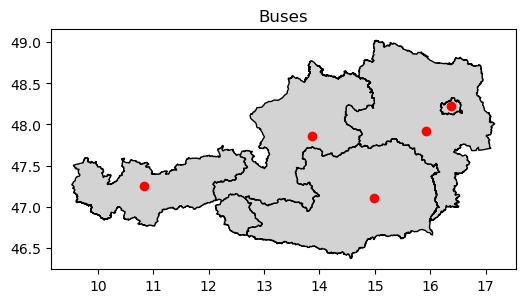

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
regions.plot(ax=ax, color="lightgrey", edgecolor="black")
ax.scatter(n.buses.x, n.buses.y, color="red", zorder=5)
ax.set_title("Buses")
plt.show()
